## Unsustainable water use

- Potential calculation of water scarcity factor by combining the water deprived equivalents with the blue water footprint dataset.

- Potential calculation of an irrigation stress intensity factor by combining the baseline water stress (bws) layer from aqueduct with the blue water footprint dataset.  
- Potential calculation of the unsustainable water consumption.  We can assume that  all consumed water is irrigated water. Green water footprint as the rainwater consumed during production. 
            Unsustainable water consumption (m3/ha *year) = (blue water footprint normalised for that crop in that pixel) / irrigation efficiency factor * harvest area in that location


Potential datasets:

- Global water footprint by crop (1996 -2005) from Water Footprint which is splited by:
    - Blue Footprint by crop
    - Green Footprint by crop
    - Grey Footprint by crop
    - Total Footprint by crop
    
    Link to dataset: "https://waterfootprint.org/media/downloads/Report47-App-IV-CropWaterFootprints-RasterMaps.zip"
    
- BWS from aqueduct

### Calculation of irrigation water consumption:
    
    We devide the blue water requirement per crop x by an efficiency value computed as the weighted average efficiencies of the applied irrigation technologies in the spatially relevant default crop inventory. 
    
    - water footprint per grid-cell (m3/year) divided by the total area of the grid-cell. 
    - in order to re-scale this to the harvested area of the crop of interest we have to divide it by the fraction of the grid-cell which is cultivated by the crop of interest. 

In [23]:
import geopandas as gpd
from shapely.geometry import Point
import rasterio as rio
import rasterio.plot
import matplotlib.pyplot as plt

In [2]:
from processing.geolocating_data import GeolocateAddress

In [3]:
## import geolocated data
input_data = gpd.read_file("../Processed_data/located_lg_data.shp")
input_data.head()

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
0,Rubber,None,2400,China,None,NaN,NaN,Unknown,Low,POINT (104.99993 35.00007)
1,Rubber,None,1300,Malaysia,None,NaN,NaN,Unknown,Low,POINT (102.26568 4.56938)
2,Rubber,None,1000,United States,None,NaN,NaN,Unknown,Low,POINT (-100.44588 39.78373)
3,Rubber,None,730,Japan,None,NaN,NaN,Unknown,Low,POINT (139.23942 36.57484)
4,Rubber,None,490,India,None,NaN,NaN,Unknown,Low,POINT (78.66774 22.35111)


In [4]:
point_location = input_data[input_data['Address']=="Henan"]
india_location = input_data[input_data['Country']=="India"].iloc[4]


In [5]:
# get geometry for india
india_loc = GeolocateAddress(query='India')

#generate gdf for india with polygon geometry
gdf_india = gpd.GeoDataFrame.from_features(india_loc.polygon_json, crs='epsg:4326')
gdf_india

Pausing 1 seconds before making HTTP GET request
Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=India with timeout=180
Geocoded "India" to (78.6677428, 22.3511148)
Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'India')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=India


,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"MULTIPOLYGON (((68.11138 23.60145, 68.11501 23...",India,35.674546,6.232527,97.395561,68.111379


## 1. Blue water footprint

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)
/opt/conda/lib/python3.8/site-packages/matplotlib/image.py:488: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


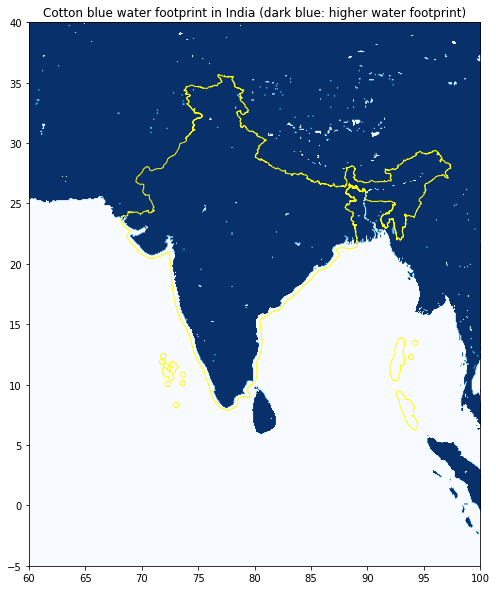

In [25]:
#import blue water footprint cotton
with rio.open('../raw_data/wfbl_mmyr_4326_cotton.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    ax.set_ylim((-5,40))
    ax.set_xlim((60,100))
    rio.plot.show(dat, vmax=100, cmap='Blues', ax=ax, transform=src.transform)
    gdf_india.plot(ax=ax, color='', edgecolor='yellow')
    ax.set_title('Cotton blue water footprint in India (dark blue: higher water footprint)')

In [26]:
point_location

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
35,Cotton,None,4800,China,Henan,NaN,NaN,"Origin supplier facility (warehouse, silo, mil...",Medium,POINT (114.00000 34.00000)


In [33]:
#generate a buffer with 100km2
geom_point_buffer = point_location.iloc[0].geometry.buffer(1)
params = {'location': ['point_location'], 'geometry':[geom_point_buffer]}
point_loc_gdf = gpd.GeoDataFrame(params, crs="EPSG:4326")
point_loc_gdf

,location,geometry
0,point_location,"POLYGON ((115.00000 34.00000, 114.99518 33.901..."


/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


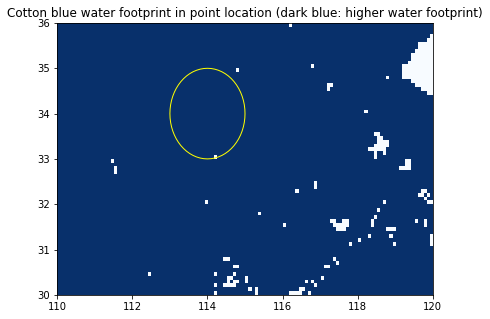

In [39]:
#import blue water footprint cotton
with rio.open('../raw_data/wfbl_mmyr_4326_cotton.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[10,5])
    ax.set_ylim((30,36))
    ax.set_xlim((110,120))
    rio.plot.show(dat, vmax=100, cmap='Blues', ax=ax, transform=src.transform)
    point_loc_gdf.plot(ax=ax, color='', edgecolor='yellow')
    ax.set_title('Cotton blue water footprint in point location (dark blue: higher water footprint)')

## 2. Aqueduct BWS

In [49]:
bws = gpd.read_file("../raw_data/aqueduct3_bws_trunc.shp")
bws.head()

,fid,DN,geometry
0,1.0,1,"POLYGON ((-39.58333 83.41667, -39.16667 83.416..."
1,2.0,0,"POLYGON ((-38.00000 83.41667, -37.83333 83.416..."
2,3.0,1,"POLYGON ((-40.75000 83.33333, -39.83333 83.333..."
3,4.0,0,"POLYGON ((-43.83333 83.16667, -43.75000 83.166..."
4,5.0,1,"POLYGON ((-39.00000 83.16667, -38.75000 83.166..."


/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


Text(0.5, 1.0, 'Aqueduct BWS in India (dark red: higher bws)')

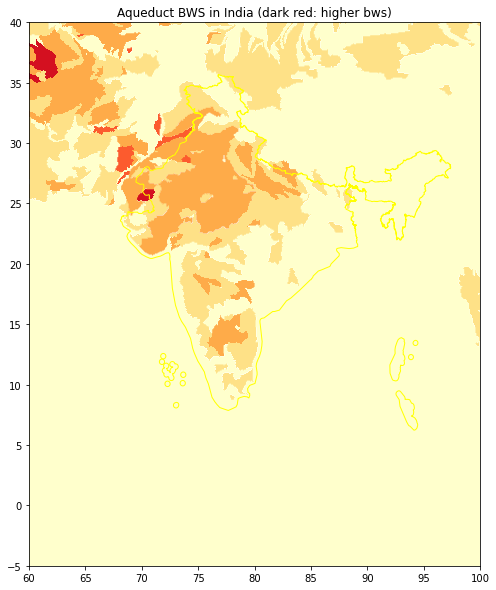

In [52]:
#import aqueduct bws 

fig, ax = plt.subplots(figsize=[15,10])
ax.set_ylim((-5,40))
ax.set_xlim((60,100))
bws.plot(ax=ax, column='DN', cmap='YlOrRd', vmin=0, vmax=5)
gdf_india.plot(ax=ax, color='', edgecolor='yellow')
ax.set_title('Aqueduct BWS in India (dark red: higher bws)')